In [1]:
import numpy as np
import matplotlib.pyplot as plt

from module.utils import *

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

In [2]:
# Set the directory containing the images
input_directory = 'data'

transform = transforms.Compose([transforms.ToTensor()])

# Create the dataset
dataset = datasets.DatasetFolder(input_directory,  transform=transform,  loader=npy_loader,  extensions=['.npy'])

# Get the class labels and split the dataset into train and test sets
class_labels = dataset.classes
train_dataset, test_dataset = train_test_split(dataset, test_size=0.20, random_state=42)

# Print the number of samples in each split
print("Train set size:", len(train_dataset))
print("Test set size:", len(test_dataset))

# Create data loaders
batch_size = 24 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train set size: 102
Test set size: 26


In [3]:
# get the mse between each pair of images
def get_mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

# get the mse between each pair of images in the dataset
def get_mse_matrix(dataset):
    n = len(dataset)
    mse_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # chech if is a tensor or numpu array
            if isinstance(dataset[i][0], torch.Tensor):
                mse_matrix[i, j] = get_mse(dataset[i][0].numpy(), dataset[j][0].numpy())
            else:
                mse_matrix[i, j] = get_mse(dataset[i][0], dataset[j][0])
    return mse_matrix

# get the mean mse between each pair of images in the dataset
def get_mean_mse(dataset):
    # only upper triangular part of the matrix
    mse_matrix = get_mse_matrix(dataset)
    mse = np.mean(mse_matrix[np.triu_indices(len(dataset), k=1)])
    return mse

# get mse flat from dataset, using only the upper triangular part of the matrix
def get_mse_flat(dataset):
    mse_matrix = get_mse_matrix(dataset)
    return mse_matrix[np.triu_indices(len(dataset), k=1)]

## Indipendece of test images between each other

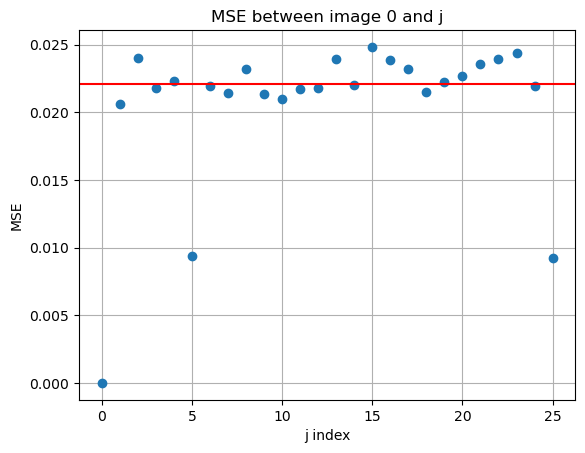

In [4]:
mse_matrix = get_mse_matrix(test_dataset)
mean_mse = get_mean_mse(test_dataset)

# plot the first row
plt.figure()
plt.plot(mse_matrix[0, :],'o')
plt.xlabel('j index')
# plot the horizontal line
plt.axhline(y=mean_mse, color='r', linestyle='-')
plt.ylabel('MSE')
plt.title('MSE between image 0 and j')
plt.grid()

### Vanilla

In [5]:
# define the model
# this is a VAE model
# for the encoder, two Conv2d layers are used to extract features from the input image
# the output image is of size 1x100x100
# first have 32 filters and kernel size 4, stride 2, padding 1
# second have 64 filters and kernel size 4, stride 2, padding 1
# then the output is flattened 
# the latent space is represented by two vectors, mean and logvar, dimension 2

# for the decoder, the latent space is first passed through a linear layer to get a tensor of size 64
# then reshaped to a tensor of size 64x1x1
# then passed through two ConvTranspose2d layers to get the output image
# first have 64 filters and kernel size 4, stride 2, padding 1
# second have 32 filters and kernel size 4, stride 2, padding 1
# the output image is of size 1x100x100

class VAE(torch.nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )
        self.fc1 = torch.nn.Linear(64*32*32, latent_dim)
        self.fc2 = torch.nn.Linear(64*32*32, latent_dim)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 64*32*32),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (64, 32, 32)),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            torch.nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc1(x)
        logvar = self.fc2(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [6]:
# load models/Emulator_vanilla.pt
model = torch.load('models/Emulator_vanilla.pt')

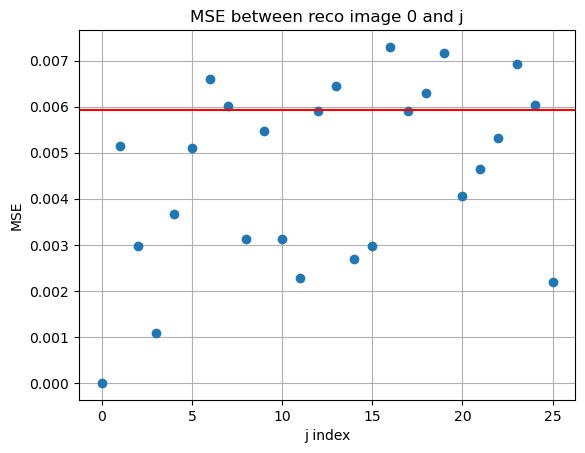

In [7]:
# get reconstruction of test
test_reco_vanilla = []
for i, (x, _) in enumerate(test_loader):
    x_reco, _, _ = model(x)
    test_reco_vanilla.append(x_reco.detach().numpy())

test_reco_vanilla = np.concatenate(test_reco_vanilla, axis=0)

# get the mse between each pair of images in the dataset
mse_matrix_vanilla = get_mse_matrix(test_reco_vanilla)
mean_mse_vanilla = get_mean_mse(test_reco_vanilla)

# plot the first row
plt.figure()
plt.plot(mse_matrix_vanilla[0, :],'o')
plt.xlabel('j index')
# plot the horizontal line
plt.axhline(y=mean_mse_vanilla, color='r', linestyle='-')
plt.ylabel('MSE')
plt.title('MSE between reco image 0 and j')
plt.grid()


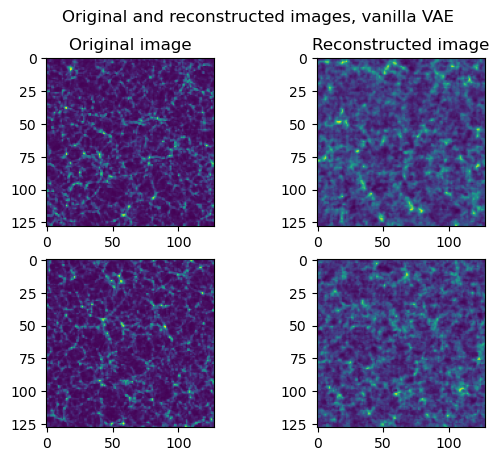

In [8]:
# show 2 images and the reconstruction in a 2x2 grid
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(test_dataset[0][0][0])
plt.title('Original image')
plt.subplot(2, 2, 2)
plt.imshow(test_reco_vanilla[0][0])
plt.title('Reconstructed image')
plt.subplot(2, 2, 3)
plt.imshow(test_dataset[1][0][0])
plt.subplot(2, 2, 4)
plt.imshow(test_reco_vanilla[1][0])
# up title for the plot
plt.suptitle('Original and reconstructed images, vanilla VAE')
# save the plot
plt.savefig('results/Original_and_reconstructed_images_vanilla_VAE.png')

In [9]:
# print the mean mse for the vanilla model and real
print("Mean MSE for vanilla model:", mean_mse_vanilla)
print("Mean MSE for real images:", mean_mse)
print("Ratio:", mean_mse_vanilla/mean_mse)

Mean MSE for vanilla model: 0.005918726389802312
Mean MSE for real images: 0.02210609023960737
Ratio: 0.2677418903862864


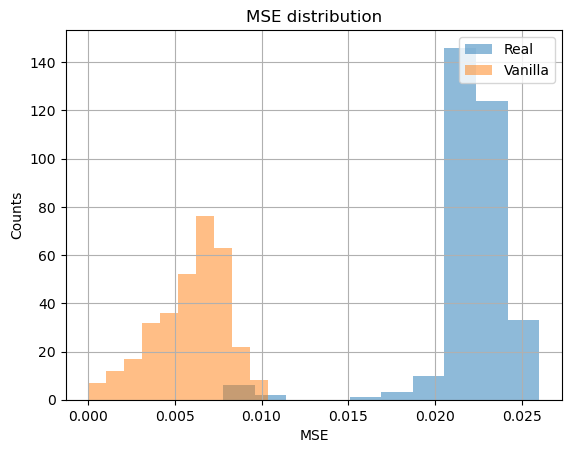

In [10]:
mse_flat = get_mse_flat(test_dataset)
mse_flat_vanilla = get_mse_flat(test_reco_vanilla)

# plot the mse flat for the vanilla model and real
plt.figure()
plt.hist(mse_flat, bins=10, alpha=0.5, label='Real')
plt.hist(mse_flat_vanilla, bins=10, alpha=0.5, label='Vanilla')
plt.legend(loc='upper right')
plt.xlabel('MSE')
plt.ylabel('Counts')
plt.title('MSE distribution')
plt.grid()
# save the plot
plt.savefig('results/MSE_distribution_vanilla.png')


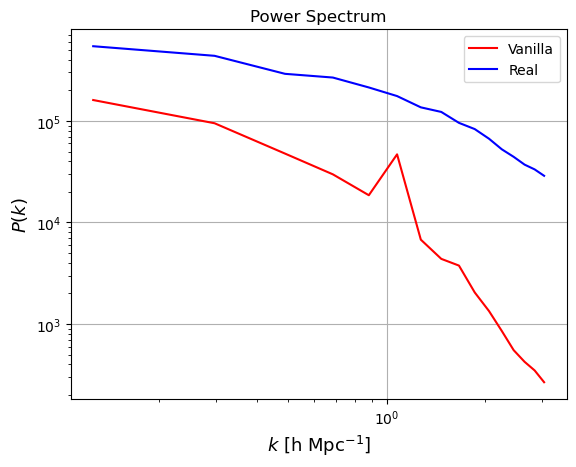

In [11]:
# get the PS of the test set
PS = mean_PS_from_dataloader(test_loader)
PS_vanilla = mean_PS_from_dataloader(test_loader, model)
plt.figure()
plt.plot(PS_vanilla[:, 0], PS_vanilla[:, 1], 'r', label='Vanilla')
plt.plot(PS[:, 0], PS[:, 1], 'b', label='Real')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k$ [h $\mathrm{Mpc^{-1}}$]', fontsize = 13)
plt.ylabel(r'$P(k)$', fontsize = 13)
plt.title('Power Spectrum')
plt.grid()
# save the plot
plt.savefig('results/Power_Spectrum_vanilla.png')

## LeafFlight tuned

In [42]:
# define the model
# this is a VAE model
# for the encoder, two Conv2d layers are used to extract features from the input image
# the output image is of size 1x128X128
# first have 32 filters and kernel size 4, stride 2, padding 1
# second have 64 filters and kernel size 4, stride 2, padding 1
# then the output is flattened 
# then  n_dense number of dense layers with n_hidden units
# the latent space is represented by two vectors, mean and logvar, dimension latent_dim

# for the decoder, the latent space is first passed through a n_dense number of dense layers with n_hidden units
# then the output is reshaped 
# two ConvTranspose2d layers are used to reconstruct the image
# the output image is of size 1x128X128

class VAE(torch.nn.Module):
    def __init__(self,n_conv =2, n_hidden=128, n_dense=1, latent_dim=2):
        super(VAE, self).__init__()
        self.n_hidden = n_hidden
        self.n_dense = n_dense
        self.latent_dim = latent_dim
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 4, stride=2, padding=1),
            torch.nn.ReLU()
        )
        # if n_conv == 2, add another Conv2d layer
        if n_conv == 3:
            self.encoder.add_module("conv2", torch.nn.Conv2d(64, 128, 4, stride=2, padding=1))
            self.encoder.add_module("relu2", torch.nn.ReLU())

        self.encoder.add_module("flatten", torch.nn.Flatten())
        
        # now the output is flattened and n_dense number of dense layers are used
        # the output is the latent space
        for i in range(n_dense):
            if i == 0:
                if n_conv == 2:
                    self.encoder.add_module("dense_{}".format(i), torch.nn.Linear(64*32*32, n_hidden))
                if n_conv == 3:
                    self.encoder.add_module("dense_{}".format(i), torch.nn.Linear(128*16*16, n_hidden))
            else:
                self.encoder.add_module("dense_{}".format(i), torch.nn.Linear(n_hidden, n_hidden))
            self.encoder.add_module("relu_{}".format(i), torch.nn.ReLU())
        
        self.mean = torch.nn.Linear(n_hidden, latent_dim)
        self.logvar = torch.nn.Linear(n_hidden, latent_dim)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, n_hidden),
            torch.nn.ReLU()
        )

        for i in range(n_dense):
            if i == n_dense-1:
                if n_conv == 2:
                    self.decoder.add_module("dense_{}".format(i), torch.nn.Linear(n_hidden, 64*32*32))
                if n_conv == 3:
                    self.decoder.add_module("dense_{}".format(i), torch.nn.Linear(n_hidden, 128*16*16))
            else:
                self.decoder.add_module("dense_{}".format(i), torch.nn.Linear(n_hidden, n_hidden))
            self.decoder.add_module("relu_{}".format(i), torch.nn.ReLU())
        
        if n_conv == 2:
            self.decoder.add_module("reshape", torch.nn.Unflatten(1, (64, 32, 32)))
        if n_conv == 3:
            self.decoder.add_module("reshape", torch.nn.Unflatten(1, (128, 16, 16)))
            self.decoder.add_module("deconv0", torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1))
            self.decoder.add_module("relu0", torch.nn.ReLU())
        
        self.decoder.add_module("deconv1", torch.nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1))
        self.decoder.add_module("relu1", torch.nn.ReLU())
        self.decoder.add_module("deconv2", torch.nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1))
        self.decoder.add_module("sigmoid", torch.nn.Sigmoid())

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar
    

In [43]:
# load models/Emulator_vanilla.pt
model = torch.load('models/Emulator_LeafFlight_tuned.pt')

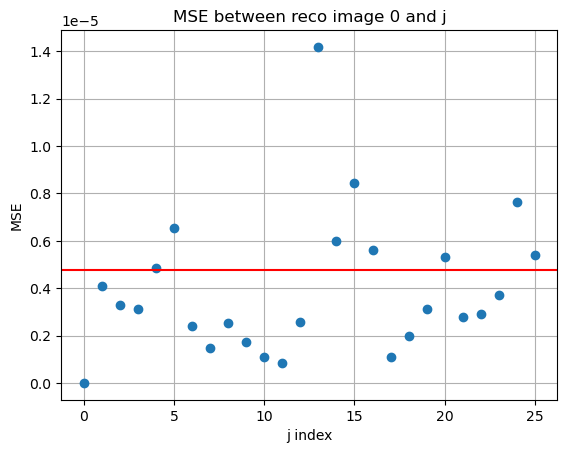

In [44]:
# get reconstruction of test
test_reco_LF = []
for i, (x, _) in enumerate(test_loader):
    x_reco, _, _ = model(x)
    test_reco_LF.append(x_reco.detach().numpy())

test_reco_LF = np.concatenate(test_reco_LF, axis=0)

# get the mse between each pair of images in the dataset
mse_matrix_LF = get_mse_matrix(test_reco_LF)
mean_mse_LF = get_mean_mse(test_reco_LF)

# plot the first row
plt.figure()
plt.plot(mse_matrix_LF[0, :],'o')
plt.xlabel('j index')
# plot the horizontal line
plt.axhline(y=mean_mse_LF, color='r', linestyle='-')
plt.ylabel('MSE')
plt.title('MSE between reco image 0 and j')
plt.grid()


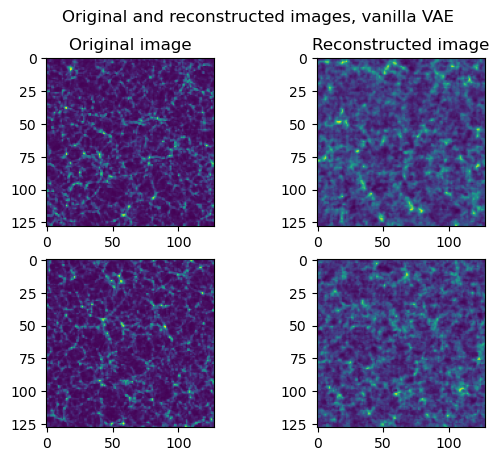

In [45]:
# show 2 images and the reconstruction in a 2x2 grid
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(test_dataset[0][0][0])
plt.title('Original image')
plt.subplot(2, 2, 2)
plt.imshow(test_reco_vanilla[0][0])
plt.title('Reconstructed image')
plt.subplot(2, 2, 3)
plt.imshow(test_dataset[1][0][0])
plt.subplot(2, 2, 4)
plt.imshow(test_reco_vanilla[1][0])
# up title for the plot
plt.suptitle('Original and reconstructed images, vanilla VAE')
# save the plot
plt.savefig('results/Original_and_reconstructed_images_vanilla_VAE.png')

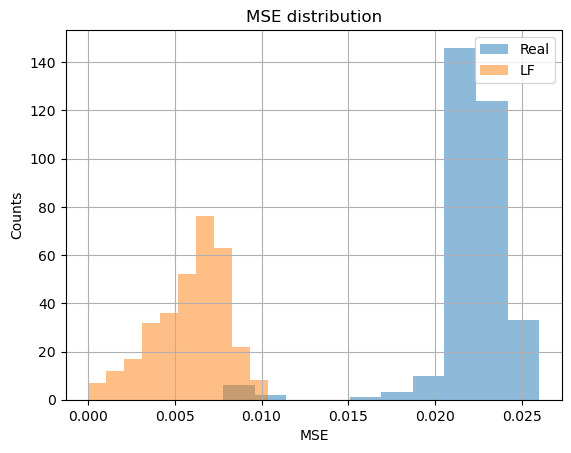

In [46]:
mse_flat = get_mse_flat(test_dataset)
mse_flat_LF = get_mse_flat(test_reco_vanilla)

# plot the mse flat for the vanilla model and real
plt.figure()
plt.hist(mse_flat, bins=10, alpha=0.5, label='Real')
plt.hist(mse_flat_LF, bins=10, alpha=0.5, label='LF')
plt.legend(loc='upper right')
plt.xlabel('MSE')
plt.ylabel('Counts')
plt.title('MSE distribution')
plt.grid()
# save the plot
plt.savefig('results/MSE_distribution_LF.png')


In [47]:
# print the mean mse for the vanilla model and real
print("Mean MSE for LF model:", mean_mse_LF)
print("Mean MSE for real images:", mean_mse)
print("Ratio:", mean_mse_LF/mean_mse)

Mean MSE for LF model: 4.756928418076383e-06
Mean MSE for real images: 0.02210609023960737
Ratio: 0.00021518632949183472


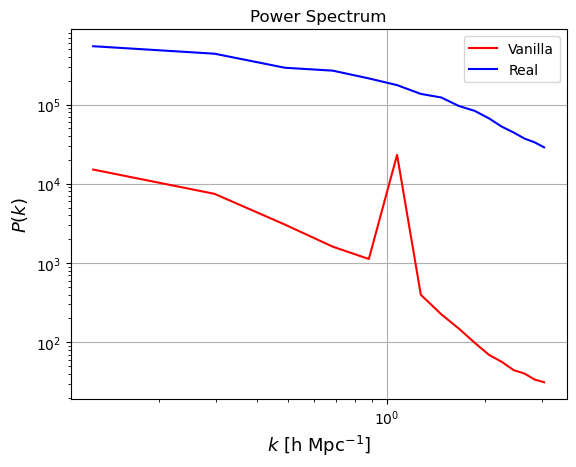

In [48]:
# get the PS of the test set
PS = mean_PS_from_dataloader(test_loader)
PS_LF = mean_PS_from_dataloader(test_loader, model)
plt.figure()
plt.plot(PS_LF[:, 0], PS_LF[:, 1], 'r', label='Vanilla')
plt.plot(PS[:, 0], PS[:, 1], 'b', label='Real')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k$ [h $\mathrm{Mpc^{-1}}$]', fontsize = 13)
plt.ylabel(r'$P(k)$', fontsize = 13)
plt.title('Power Spectrum')
plt.grid()
# save the plot
plt.savefig('results/Power_Spectrum_vanilla.png')

## Longtrain model

Mean MSE for LF model: 0.0096803091948543
Mean MSE for real images: 0.02210609023960737
Ratio: 0.4379023649107402


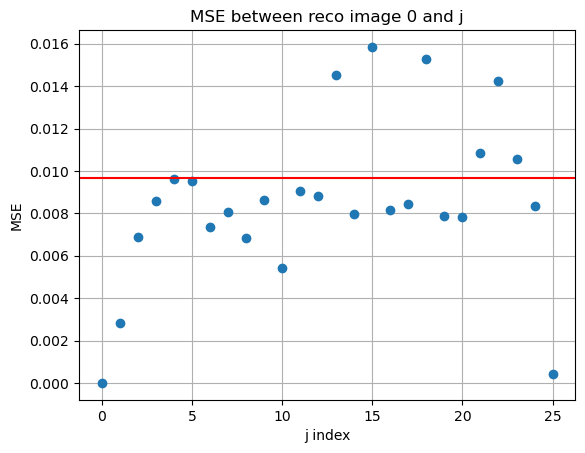

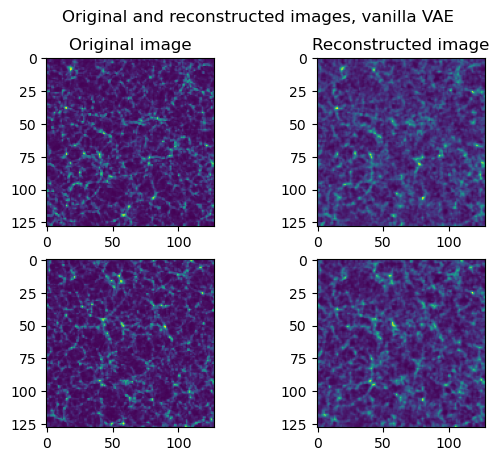

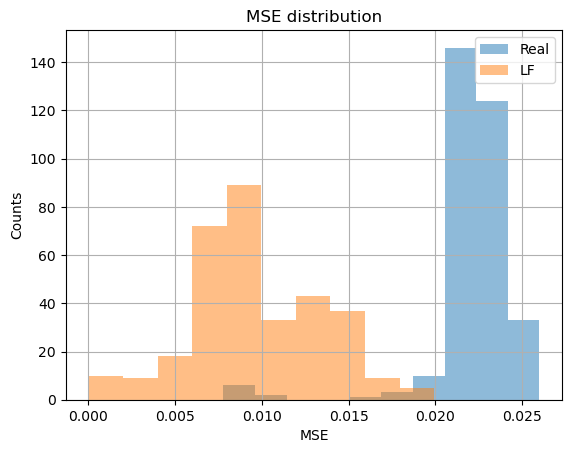

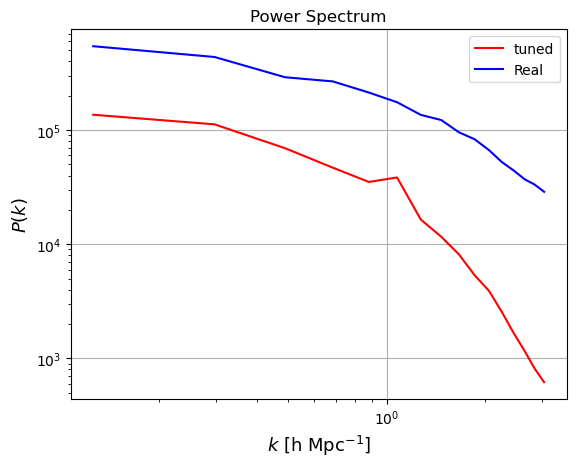

In [52]:
# load models/Emulator_vanilla.pt
model = torch.load('models/Emulator_longtrain.pt')
# get reconstruction of test
test_reco_LT = []
for i, (x, _) in enumerate(test_loader):
    x_reco, _, _ = model(x)
    test_reco_LT.append(x_reco.detach().numpy())

test_reco_LT = np.concatenate(test_reco_LT, axis=0)

# get the mse between each pair of images in the dataset
mse_matrix_LT = get_mse_matrix(test_reco_LT)
mean_mse_LT = get_mean_mse(test_reco_LT)

# plot the first row
plt.figure()
plt.plot(mse_matrix_LT[0, :],'o')
plt.xlabel('j index')
# plot the horizontal line
plt.axhline(y=mean_mse_LT, color='r', linestyle='-')
plt.ylabel('MSE')
plt.title('MSE between reco image 0 and j')
plt.grid()

# show 2 images and the reconstruction in a 2x2 grid
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(test_dataset[0][0][0])
plt.title('Original image')
plt.subplot(2, 2, 2)
plt.imshow(test_reco_LT[0][0])
plt.title('Reconstructed image')
plt.subplot(2, 2, 3)
plt.imshow(test_dataset[1][0][0])
plt.subplot(2, 2, 4)
plt.imshow(test_reco_LT[1][0])
# up title for the plot
plt.suptitle('Original and reconstructed images, vanilla VAE')
# save the plot
plt.savefig('results/Original_and_reconstructed_images_vanilla_VAE.png')
mse_flat = get_mse_flat(test_dataset)
mse_flat_LT = get_mse_flat(test_reco_LT)

# plot the mse flat for the vanilla model and real
plt.figure()
plt.hist(mse_flat, bins=10, alpha=0.5, label='Real')
plt.hist(mse_flat_LT, bins=10, alpha=0.5, label='LF')
plt.legend(loc='upper right')
plt.xlabel('MSE')
plt.ylabel('Counts')
plt.title('MSE distribution')
plt.grid()
# save the plot
plt.savefig('results/MSE_distribution_LT.png')

# print the mean mse for the vanilla model and real
print("Mean MSE for LF model:", mean_mse_LT)
print("Mean MSE for real images:", mean_mse)
print("Ratio:", mean_mse_LT/mean_mse)
# get the PS of the test set
PS = mean_PS_from_dataloader(test_loader)
PS_LT = mean_PS_from_dataloader(test_loader, model)
plt.figure()
plt.plot(PS_LT[:, 0], PS_LT[:, 1], 'r', label='tuned')
plt.plot(PS[:, 0], PS[:, 1], 'b', label='Real')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k$ [h $\mathrm{Mpc^{-1}}$]', fontsize = 13)
plt.ylabel(r'$P(k)$', fontsize = 13)
plt.title('Power Spectrum')
plt.grid()
# save the plot
plt.savefig('results/Power_Spectrum_longtrain.png')

## Compare  vanilla and longtrain

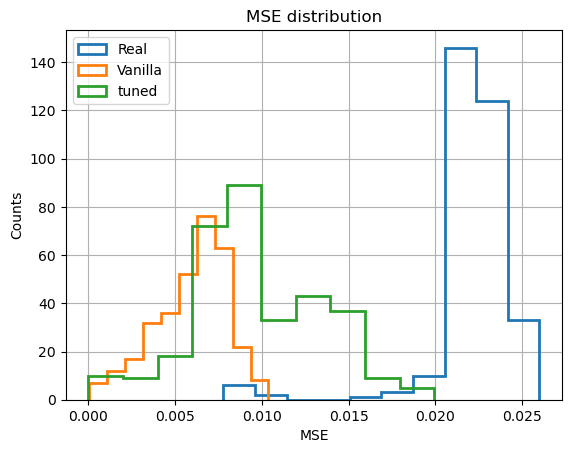

In [66]:
# plot the histogram of mse_vanilla mse_LT and mse real
# histogram only line
plt.figure()
plt.hist(mse_flat, bins=10, label='Real', histtype='step', linewidth=2)
plt.hist(mse_flat_vanilla, bins=10, label='Vanilla', histtype='step', linewidth=2)
plt.hist(mse_flat_LT, bins=10, label='tuned', histtype='step', linewidth=2)
plt.legend(loc='upper left')
plt.xlabel('MSE')
plt.ylabel('Counts')
plt.grid()
plt.title('MSE distribution')
plt.savefig('results/MSE_distribution_all.png')

In [61]:
# print the mean mse for the three
print("Mean MSE for vanilla model:", mean_mse_vanilla)
print("Mean MSE for LF model:", mean_mse_LF)
print("Mean MSE for LT model:", mean_mse_LT)
print("Mean MSE for real images:", mean_mse)

Mean MSE for vanilla model: 0.005918726389802312
Mean MSE for LF model: 4.756928418076383e-06
Mean MSE for LT model: 0.0096803091948543
Mean MSE for real images: 0.02210609023960737


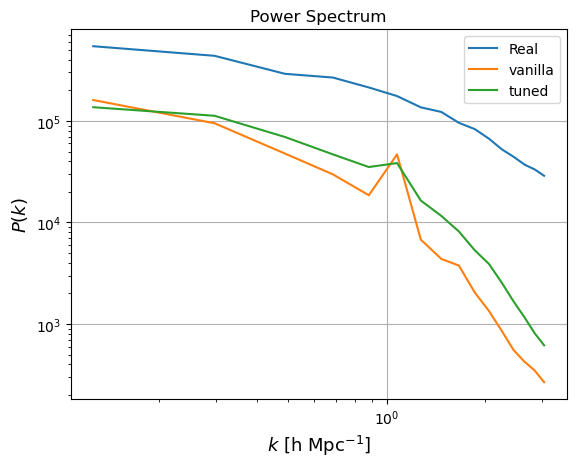

In [70]:
# plot the PS for the three
plt.figure()
plt.plot(PS[:, 0], PS[:, 1], label='Real')
plt.plot(PS_vanilla[:, 0], PS_vanilla[:, 1], label='vanilla')
plt.plot(PS_LT[:, 0], PS_LT[:, 1], label='tuned')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k$ [h $\mathrm{Mpc^{-1}}$]', fontsize = 13)
plt.ylabel(r'$P(k)$', fontsize = 13)
plt.title('Power Spectrum')
plt.grid()

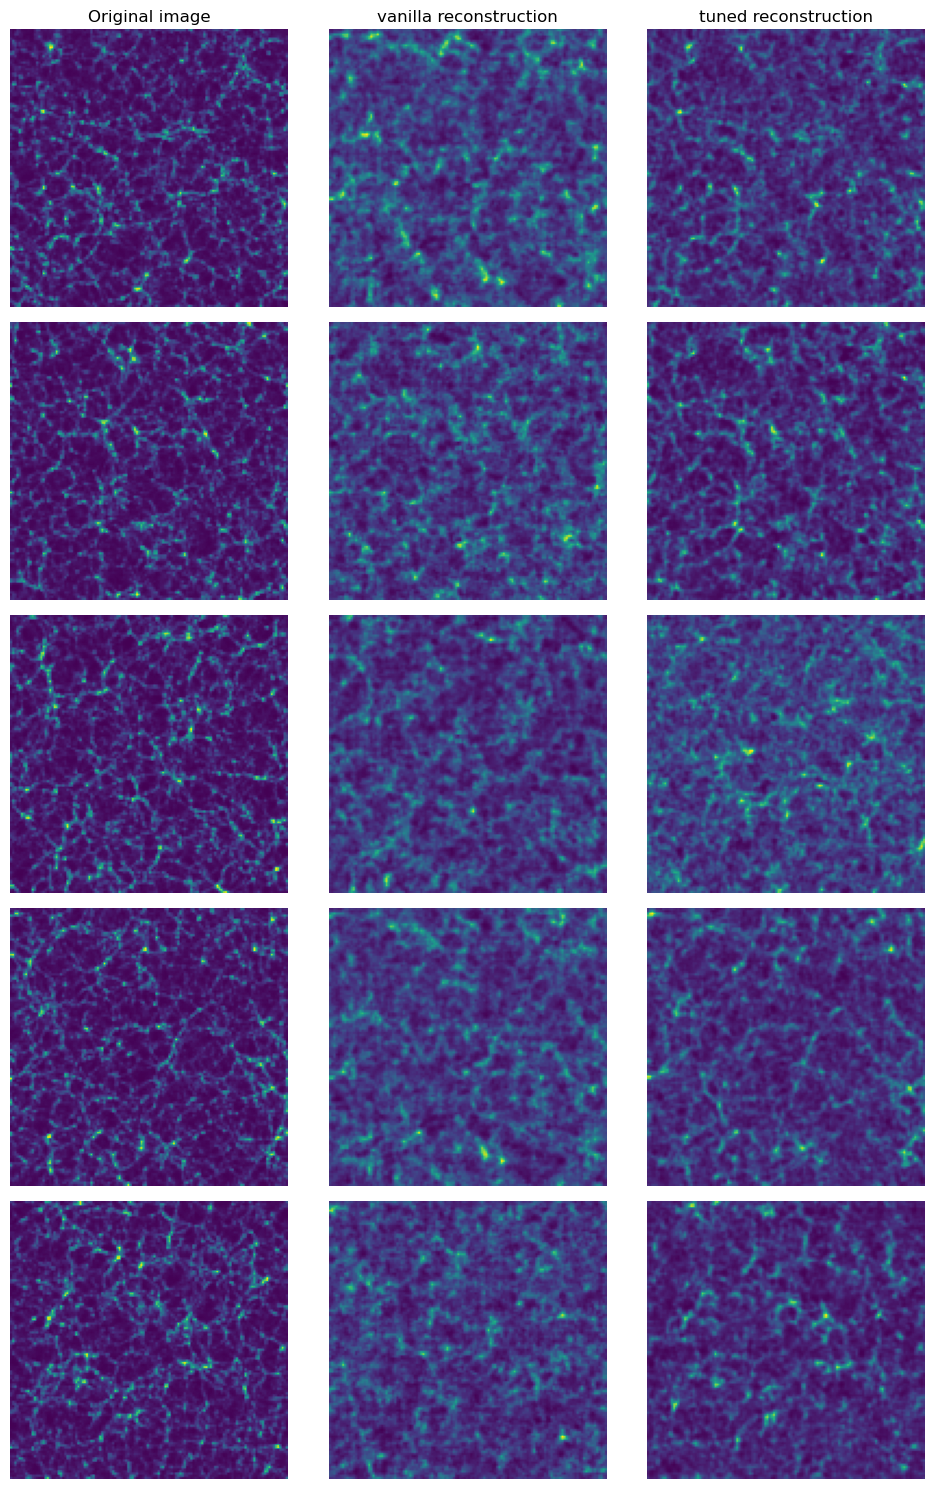

In [80]:
# make a figure with 3 colum, 5 rows
# first column is the original image, second column is the vanilla reconstruction, third column is the LT reconstruction
# for each row different images

plt.figure(figsize=(10, 15))
for i in range(5):
    # put the title only in the first row
    if i == 0:
        plt.subplot(5, 3, 3*i+1)
        plt.title('Original image')
    else:
        plt.subplot(5, 3, 3*i+1)
    plt.imshow(test_dataset[i][0][0])
    plt.axis('off')
    plt.subplot(5, 3, 3*i+2)
    plt.imshow(test_reco_vanilla[i][0])
    if i == 0:
        plt.title('vanilla reconstruction')
    plt.axis('off')
    plt.subplot(5, 3, 3*i+3)
    plt.imshow(test_reco_LT[i][0])
    if i == 0:
        plt.title('tuned reconstruction')
    plt.axis('off')
plt.tight_layout()

# save the plot
plt.savefig('results/Original_and_reconstructed_images.png')